# Install Dependencies

In [7]:
%pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "c:\Users\Asus Vivo Book\Documents\Vs Code\CommentToxicity\.venv\Lib\site-packages\packaging\requirements.py", line 36, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\Asus Vivo Book\Documents\Vs Code\CommentToxicity\.venv\Lib\site-packages\packaging\_parser.py", line 62, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\Asus Vivo Book\Documents\Vs Code\CommentToxicity\.venv\Lib\site-packages\packaging\_parser.py", line 80, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
                                  

In [8]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [9]:
df = pd.read_csv(os.path.join('comment-classification','train.csv', 'train.csv'))

In [10]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Preprocess

In [11]:
%pip list

Package                 Version
----------------------- -----------
absl-py                 2.3.0
asttokens               3.0.0
astunparse              1.6.3
certifi                 2025.6.15
charset-normalizer      3.4.2
colorama                0.4.6
comm                    0.2.2
debugpy                 1.8.14
decorator               5.2.1
executing               2.2.0
flatbuffers             25.2.10
gast                    0.6.0
google-pasta            0.2.0
grpcio                  1.73.0
h5py                    3.14.0
idna                    3.10
ipykernel               6.29.5
ipython                 9.3.0
ipython_pygments_lexers 1.1.1
jedi                    0.19.2
jupyter_client          8.6.3
jupyter_core            5.8.1
keras                   3.10.0
libclang                18.1.1
Markdown                3.8
markdown-it-py          3.0.0
MarkupSafe              3.0.2
matplotlib-inline       0.1.7
mdurl                   0.1.2
ml_dtypes               0.5.1
namex                 

In [12]:
from tensorflow.keras.layers import TextVectorization

X = df['comment_text']
y = df[df.columns[2:]].values

In [13]:
MAX_FEATURES = 200000 # number of words in the vocab

In [14]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=32,
                               output_mode='int')

In [15]:
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

In [16]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [17]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# Create Sequential Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [19]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()
history = model.fit(train, epochs=1, validation_data=val)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

6981/6981 ━━━━━━━━━━━━━━━━━━━━ 494s 69ms/step - loss: 0.0880 - val_loss: 0.0503


<Figure size 800x500 with 0 Axes>

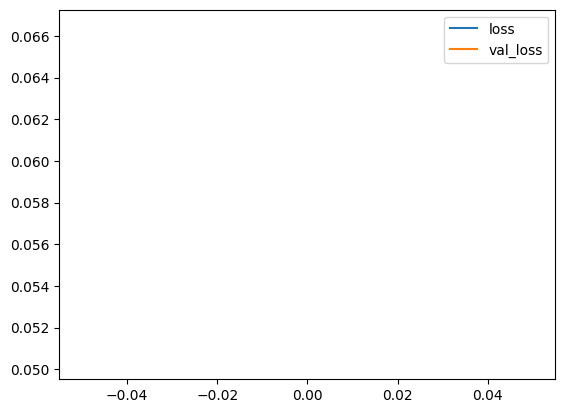

In [21]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Make Predictions

In [22]:
input_text = vectorizer('You freaking suck! I am going to hit you.')
input_array = np.array([input_text])
res = model.predict(input_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


In [24]:
(res > 0.5).astype(int)
batch_X, batch_y = test.as_numpy_iterator().next()
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [25]:
res.shape

(1, 6)

# Evaluate Model

In [26]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [27]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━

In [28]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8492230176925659, Recall:0.6160877346992493, Accuracy:0.49548646807670593


# Test and Gradio

In [29]:
%pip install gradio jinja2

import tensorflow as tf
import gradio as gr

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached anyio-4.9.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached fastapi-0.115.12-py3-none-any.whl.metadata (27 kB)
  Using cached ffmpy-0.6.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached gradio_client-1.10.3-py3-none-any.whl.metadata (7.1 kB)
  Using cached groovy-0.1.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached huggingface_hub-0.33.0-py3-none-any.whl.metadata (14 kB)
  Using cached orjson-3.10.18-cp312-cp312-win_amd64.whl.metadata (43 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached python_multipart-0.0.20-py3-none-any.whl.metadata (1.8 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-win_amd64.whl.metadata (2.1 kB)
  Using cached ruff-0.11.13-py3-none-win_amd64.whl.metadata (26 kB)
  Using cached safehttpx-0.1.6-py3-none-any.whl.metadata (4

c:\Users\Asus Vivo Book\Documents\Vs Code\CommentToxicity\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
model.save('toxicity.h5')
model = tf.keras.models.load_model('toxicity.h5')

In [32]:
input_str = vectorizer('hey i freaken hate you!')
res = model.predict(np.expand_dims(input_str,0))
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


array([[0.74779445, 0.00743474, 0.20943433, 0.01663082, 0.29244265,
        0.05320308]], dtype=float32)

In [33]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [34]:
interface = gr.Interface(
                        fn=score_comment, 
                        inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [35]:
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://eeeb53e49d5ccc7927.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
